# Chapter 14. Deep Computer Vision Using Convolutional Neural Networks

project goal: CNN (Convolutional Neural Networks)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# Convolutional Layer (摺積網路)

* 在 convolutional layer 中的每一個神經元, 不會連接到每一個輸入, 而是只會連接到它感受區裡面的像素
* 這麼做可以讓前面的隱藏層先專注於低階的小特徵, 後面的隱藏層再將它們慢慢組合成較大的高階特徵, 而這也是CNN擅長圖像處理的原因
* 而為了讓每一層的shape都保持一樣, 會在輸入周圍補上零, 稱為 zero padding (例如: (5,5)的輸入遇到(3,3)的filter, 輸入應該會是(3,3), 所以要先將輸入從(5,5)補零到(7,7))
* 從一個感受區一到下一個感受區的位移大小稱為 stride(步幅)

# Filter (過濾器, convolution kernel 摺積核)

* 讓所有的神經元都使用同一種filter之後得到的階層會輸出 特徵圖(feature map)
* 一個convolution layer裡面會有很多過濾器同時使用, 所以輸出其實會是多張特徵圖相疊 (比較像3D)
* 且 通常輸入圖片會由多個顏色channel組成(常見是RGB), 除非是黑白的(只有一個通道)

# 實作1: 圖片

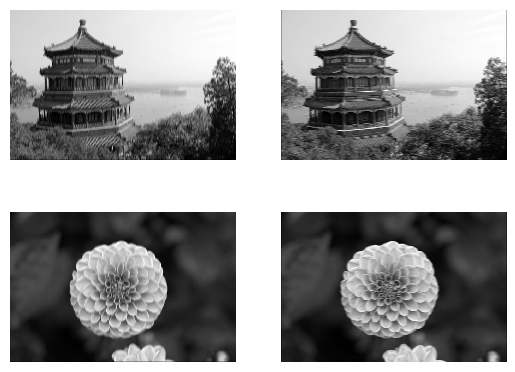

In [ ]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
# 所以這兩個filters看起來會像是:
# 0 0 0 1 0 0 0         0 0 0 0 0 0 0
# 0 0 0 1 0 0 0         0 0 0 0 0 0 0
# 0 0 0 1 0 0 0         0 0 0 0 0 0 0
# 0 0 0 1 0 0 0    &    1 1 1 1 1 1 1
# 0 0 0 1 0 0 0         0 0 0 0 0 0 0
# 0 0 0 1 0 0 0         0 0 0 0 0 0 0
# 0 0 0 1 0 0 0         0 0 0 0 0 0 0

# padding="SAME", 代表 zero padding; 
# padding="VALID", 代表不做padding, 單純不考慮超出範圍的像素
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

Original Image


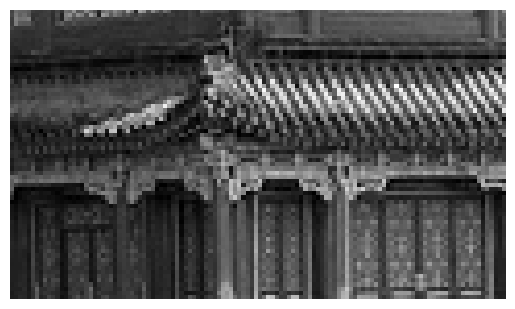

Feature Map 0


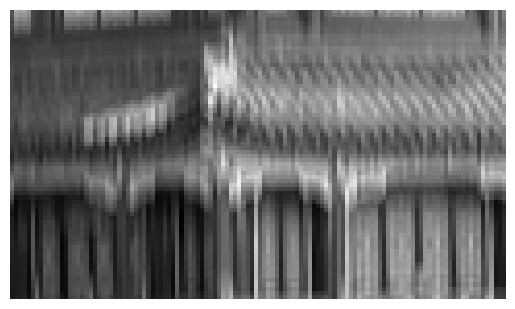

Feature Map 1


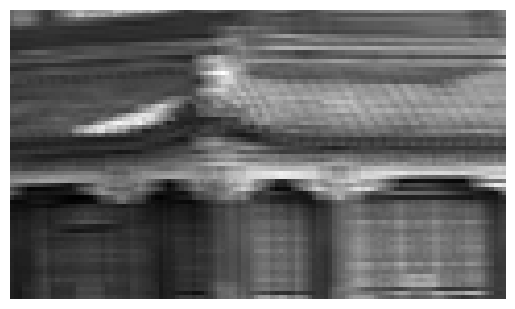

In [ ]:
# 放大來看細部:
def crop(images):
    return images[150:220, 130:250]

plot_image(crop(images[0, :, :, 0]))
print("Original Image")
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    print("Feature Map", feature_map_index)
    plt.show()

# Convolutional Layer

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# conv layer自己會去訓練出哪些filters及biases的效果最好, 所以我們幾乎不會需要自己指定！
conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

conv_outputs = conv(images)
conv_outputs.shape
# [2, 427, 640, 2] 代表 [num_of_images, height, width, channels(filters)]

TensorShape([2, 427, 640, 2])

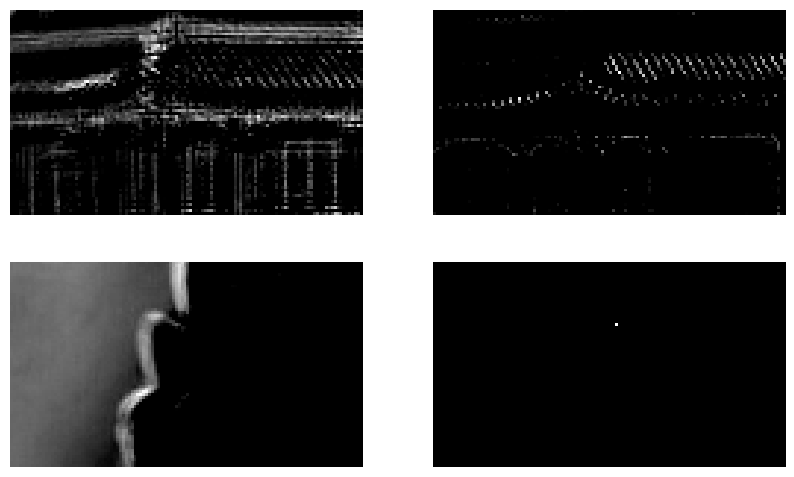

In [ ]:
plt.figure(figsize=(10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

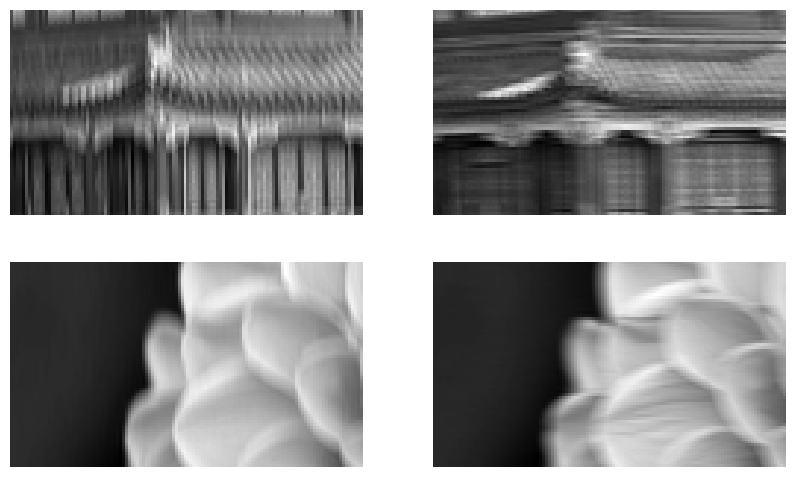

In [ ]:
# 雖然conv layer會自動找到最好的filter & bias, 我們也可以自己指定(但其實不太可能用到)
conv.set_weights([filters, np.zeros(2)])
conv_outputs = conv(images)

plt.figure(figsize=(10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))

plt.show()


# Pooling Layer (池化層)

* pooling layer 的目的是 抽取輸入圖像的子樣本(也就是縮小他)來降低計算負擔, 圖時也降低overfitting的風險
* 原理上跟 conv layer 很像, 一樣有感知區、步幅、padding等, 但pooling layer單純只使用aggregate函數來匯集輸入(可以是取感知區內的max, mean...等值), 進而縮小input

1. Max Pooling (最大池化層): 最常見, 取pooling kernel內的最大值

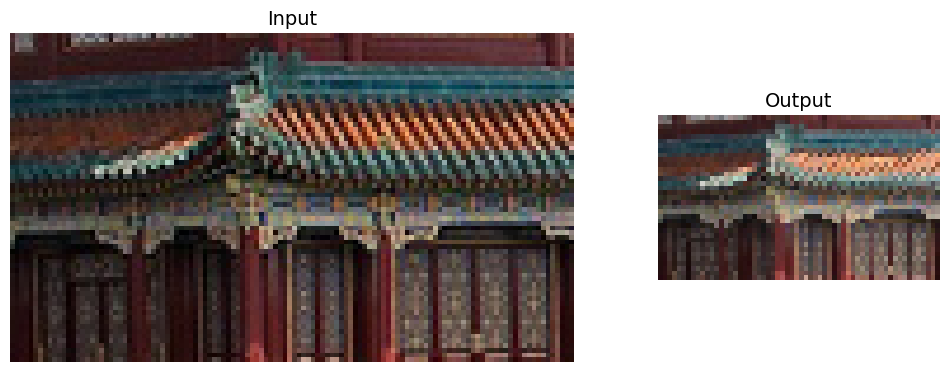

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")
plt.show()

Max Pooling 的優點:
* 為小幅度的平移加入一些 不變性(invariance): 當圖像稍微向某個特定方向進行小幅度平移時, max pooling的kernel還是可以得出很高的不變性
* 這個優點可以在 分類任務 時, 確保預測結果不太容易被這些平移細節影響到

Max Pooling 的缺點:
* 破壞性很強: 面積縮小很多(即使使用2*2的核加上stride=2, 面積會直接縮小成1/4)
* 不變性有時候不是好事: 例如, 當 任務是輸出圖像 時, 輸入圖像被右移一個像素後, 會希望輸出的圖像也跟著右移一格, 稱為 同變性(equivariance)

2. Average Pooling (平均池化層): 取kernel內的平均值
* 將 MaxPool2D 換成 AvgPool2D 即可
* 通常 max pooling 的表現會比較好, 因為他會保留最強的特徵而捨棄其他者, 比起 avg pooling 更能讓下一層有明確的訊號可以處理；此外, 平移不變性也是 max pooling 勝過 avg pooling

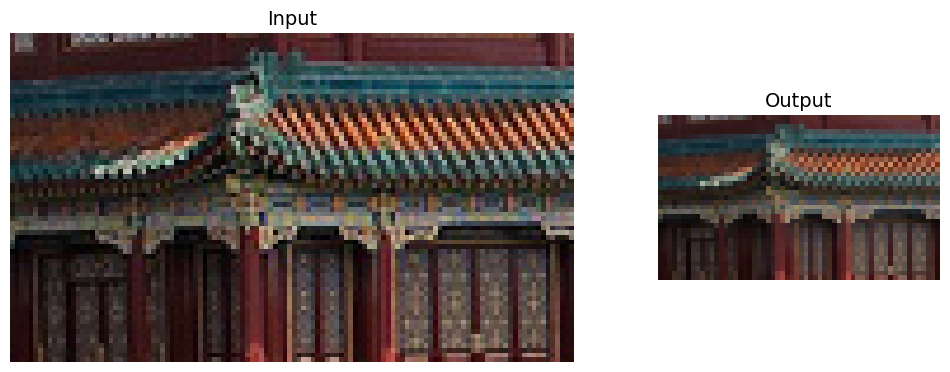

In [ ]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])
ax2.axis("off")
plt.show()

3. Depth-wise Pooling: 
* 除了前兩者的空間維度, pooling也可以沿著深度維度進行
* 適合用來針對特定的特徵學習其不變性, 例如粗細、亮度、旋轉、顏色等
* 以 Depth Max Pooling 來說, 可以把多個filter分別向一張圖片的各種旋轉結果去做偵測, 就能確保無論圖形如何旋轉, 輸出都會是相同的

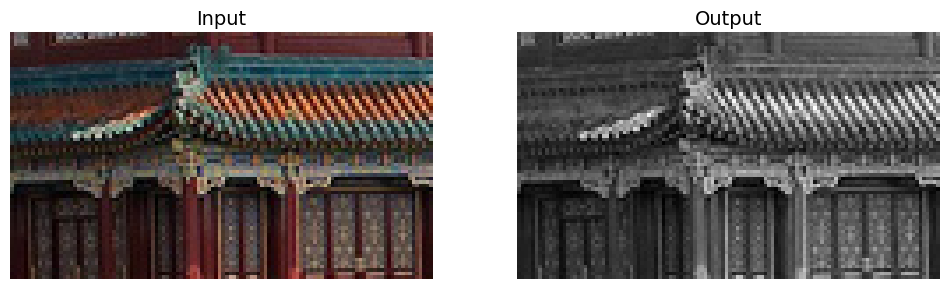

In [ ]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs, 
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)
    
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

# CNN Structure

典型的CNN架構: input -> conv -> pool -> conv -> pool ... -> fully-connected network -> ... -> softmax

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
# 當我們要呼叫某個函式多次, 但某些參數是固定的, 就可以用partial簡化
# 但這裡為了讓模型架構更直觀, 暫時先不用
'''
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")
'''

# 注意：不要使用太大的conv kernel！
# 除了第一個conv layer之外, 其他時候要把大的kernel(5以上)拆成多個小的kernel！

model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

上述模型結構的討論:
1. 除了第一層convolution layer會使用較大的filter之外, 其他時候要使用多層小的kernel組合
2. filter的數量會越來越多, 因為低階特徵的數量通常很少, 但將他們組成高階特徵的方法會很多, 所以通常會在每經過一個池化層後就將filter加倍 (而且filter雖然加倍, 但pooling會縮小輸入, 所以運算負擔也不會過量)
3. 接著是 全連接層網路, 由 兩個 hidden Dense layer + 一個 output Dense layer組成, 在這之前需要先用 Flatten() 壓成1D (因為Dense()只接收1D array)
4. 其中加入兩個dropout層, 用以避免overfitting

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 141s 82ms/step - loss: 0.6984 - accuracy: 0.7566 - val_loss: 0.3967 - val_accuracy: 0.8590
Epoch 2/10
1719/1719 [==============================] - 150s 87ms/step - loss: 0.4115 - accuracy: 0.8623 - val_loss: 0.3240 - val_accuracy: 0.8836
Epoch 3/10
1719/1719 [==============================] - 153s 89ms/step - loss: 0.3603 - accuracy: 0.8795 - val_loss: 0.3057 - val_accuracy: 0.8904
Epoch 4/10
1719/1719 [==============================] - 164s 96ms/step - loss: 0.3302 - accuracy: 0.8890 - val_loss: 0.2861 - val_accuracy: 0.8980
Epoch 5/10
1719/1719 [==============================] - 169s 98ms/step - loss: 0.3056 - accuracy: 0.8963 - val_loss: 0.2688 - val_accuracy: 0.9004
Epoch 6/10
1719/1719 [==============================] - 168s 98ms/step - loss: 0.2897 - accuracy: 0.9023 - val_loss: 0.2787 - val_accuracy: 0.8990
Epoch 7/10
1719/1719 [==============================] - 170s 99ms/step - loss: 0.2779 - accuracy: 0.9050 - val_loss: 0

# 常見CNN架構

例如: 
* LeNet-5: 廣泛運用於手寫字辨識上, 見 p.449 ~ p.450
* AlexNet: 見 p.450 ~ p.452
* GoogLeNet: 見 p.453 ~ p.455
* VGGNet: 見 p.456
* ResNet-34: 下面會重點介紹
* Xception: 見 p.459 ~ p.461
* SENet: 見 p.461 ~ p.462

# ResNet-34

* 隨著前面幾種CNN進步至ResNet, 證明了模型應該要愈來愈深, 且參數愈來愈少
* ResNet的關鍵是 跳接(skip/shortcut connection), 傳給某一層的訊號也會被加到更高幾層的輸出中
* residual learning: 把x加到某一層中, 讓模型從模擬 f(x) = h(x), 變成 f(x) = h(x) - x, 這就是 殘差學習(residual learning)
* Residual Unit(RU): 可以把每一個有跳接的地方都當成一個小的RU, 這樣深的殘差網路就可以看成很多個RU的堆疊

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, 
                        padding="SAME", use_bias=False)

# 每一個 residual unit 的結構都是這樣
# input -> Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> + -> ReLU -> output
#    ↳-------------------------------------------------------⇡
# 
# 

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
    
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 residual_unit (ResidualUni  (None, 56, 56, 64)        74240     
 t)                                                              
                                                      

# 實作: 運用 Keras 中的 pre-trained ResNet

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")
# 上面這段函式, keras會建立一個ResNet-50模型, 並下載使用ImageNet資料組訓練好的權重
# 需要注意的是, ResNet-50模型預期接收224*224的圖片, 所以需要resize

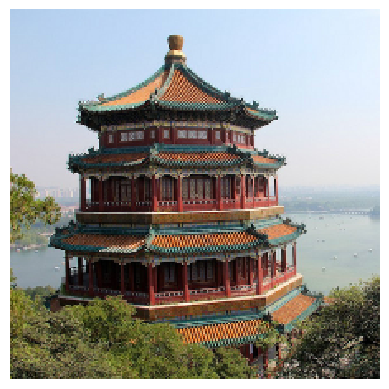

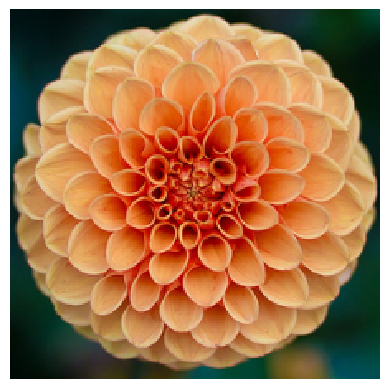

In [ ]:
# 如果直接用 image.resize() 會破壞原來的長寬比
# 所以應該用 crop_and_resize()
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [ ]:
# 每一個model都有他的preprocess_input(), 記得先call
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)
# Y_proba.shape = (2, 1000), 代表對這兩張圖片預測屬於1000個類別的機率

top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

# 預測的結果如下, 圖片1預測是宮殿、鐘樓或修道院(✓), 圖片2預測是花瓶、杯子或菊花( ✓)

35363/35363 [==============================] - 0s 1us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.08%
  n03781244 - monastery    11.69%

Image #1
  n04522168 - vase         53.97%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.96%



# 實作: 運用 Keras 中的 pre-trained Xception 來做 Transfer Learning(遷移學習)

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples   # 3670
class_names = info.features["label"].names         # ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
n_classes = info.features["label"].num_classes     # 5

2024-01-05 15:15:57.647425: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /Users/chenyanting/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


2024-01-05 15:28:00.974673: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


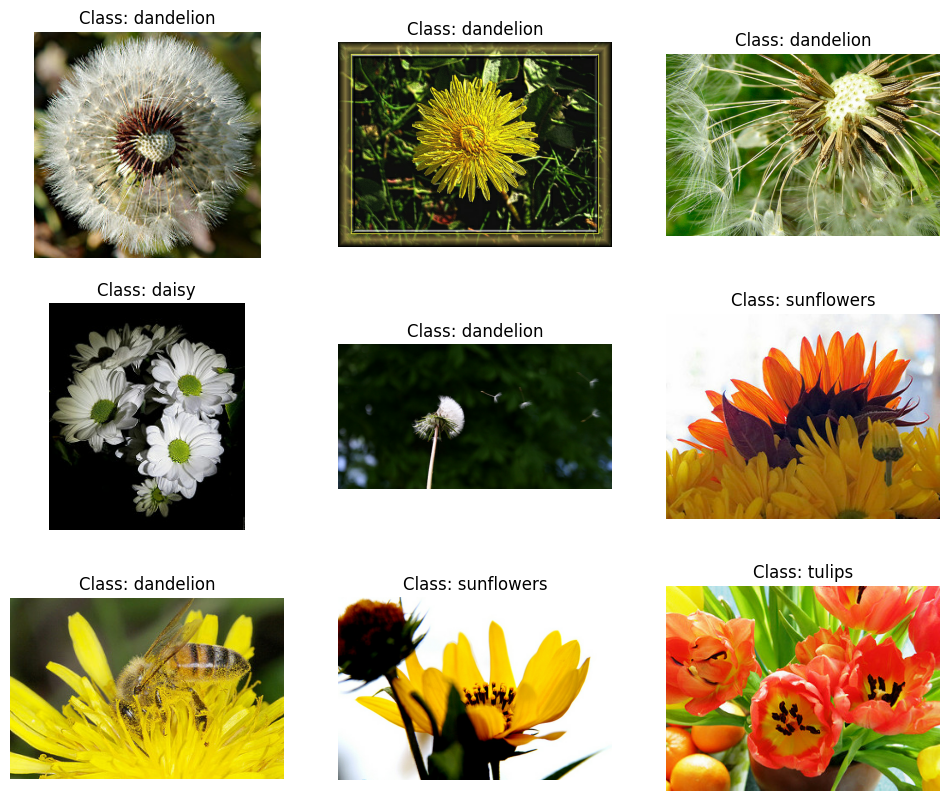

In [ ]:
# 將資料集前10%做為test_set, 後15%做為validation_set, 最後75%當作train_set
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
    )

plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [ ]:
# Preprocessing: 裁成224*224, 以及先call proprocess_input()
# 兩種截成局部圖的方式: 裁正中間, 或是隨機裁剪

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

2024-01-05 15:45:39.126675: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


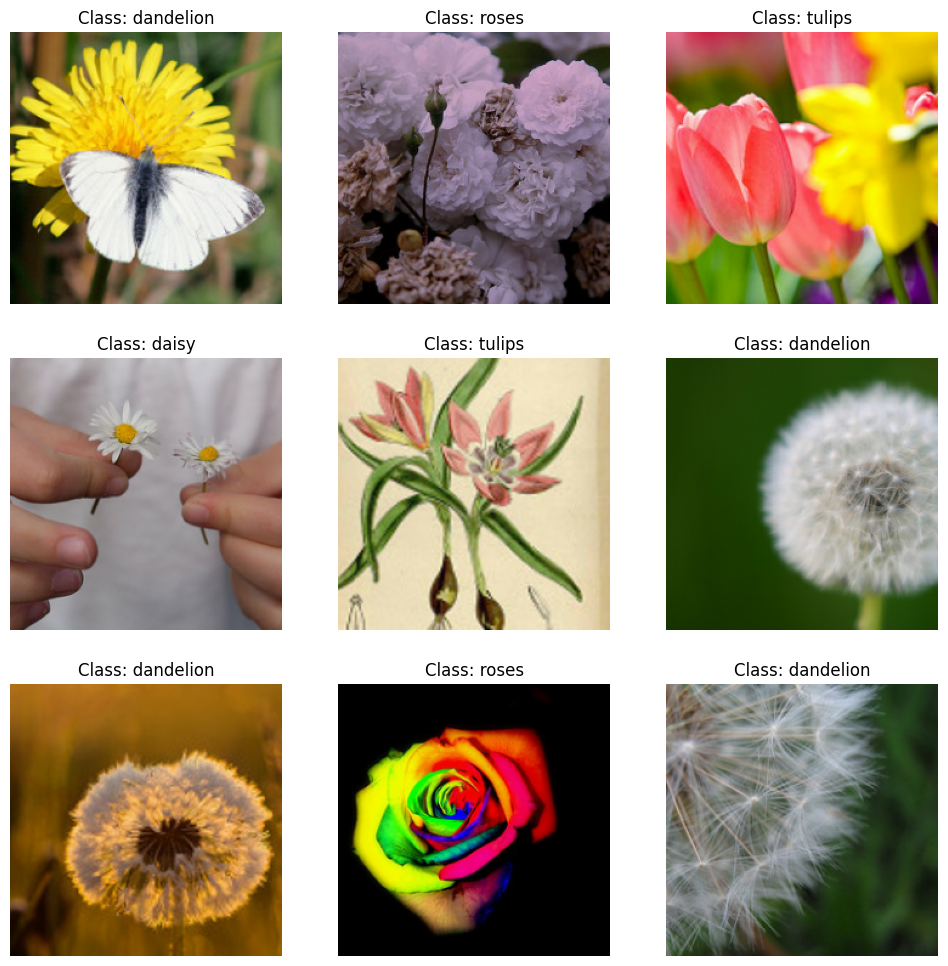

In [ ]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index+1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [ ]:
# pre-trained model 使用 Xception (架構總共有131層)
# include_top=False 是因為我們要用自己的 GlobalAvgPool 及 Dense layer
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

# 遷移學習一開始會先維持訓練好的模型權重, 再慢慢一層一層解凍
for layer in base_model.layers:
    layer.trainable = False
# 先訓練一點epoch, 例如5
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 120s 1s/step - loss: 0.9768 - accuracy: 0.8096 - val_loss: 1.0168 - val_accuracy: 0.8088
Epoch 2/5
86/86 [==============================] - 124s 1s/step - loss: 0.5192 - accuracy: 0.8892 - val_loss: 0.7670 - val_accuracy: 0.8658
Epoch 3/5
86/86 [==============================] - 797s 9s/step - loss: 0.2724 - accuracy: 0.9270 - val_loss: 0.7485 - val_accuracy: 0.8676
Epoch 4/5
86/86 [==============================] - 116s 1s/step - loss: 0.2205 - accuracy: 0.9375 - val_loss: 0.6756 - val_accuracy: 0.8713
Epoch 5/5
86/86 [==============================] - 125s 1s/step - loss: 0.1711 - accuracy: 0.9462 - val_loss: 0.5994 - val_accuracy: 0.8732


In [ ]:
# 解凍其他層後繼續訓練
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

# 他會跑很久XD 反正最後accuracy可以到95%啦

# 實作: Classification & Localization